<a href="https://colab.research.google.com/github/SreeDurga28/Face-detection/blob/main/FaceDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import imutils
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

In [2]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [5]:
image_file = take_photo()

<IPython.core.display.Javascript object>

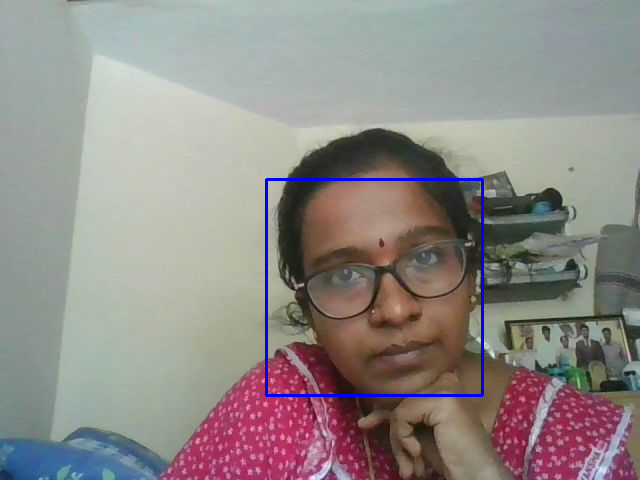

In [8]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
#Reading the image
img=cv2.imread(image_file,1)
# Reading the image as gray scale image
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# Search the co-ordintes of the image
faces = face_cascade.detectMultiScale(gray_img, scaleFactor = 1.3, minNeighbors=4)
for x,y,w,h in faces:
    img = cv2.rectangle(img, (x,y), (x+w,y+h),(255,0,0),2)
 
#resized = cv2.resize(img, (int(img.shape[1]/7),int(img.shape[0]/7)))
 
cv2_imshow(img)
 
cv2.waitKey(0)
 
cv2.destroyAllWindows()